# Argo one filter scale

In [118]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

## Load boxes

In [40]:
import filt_funcs as ff
import my_stats

#### Same boxes and naming conventions as the AGU_poster notebook

In [49]:
#North Pacific
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")
np = ff.get_ds_interp(np_ds,0,2000,4)

#North Atlantic
na_ds=xr.open_dataset("202206_lon:(-55,-45)_lat:(40,45).nc")
na = ff.get_ds_interp(na_ds,0,2000,4)

#Souterh Ocean
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
so = ff.get_ds_interp(so_ds,0,2000,4)

#Indian Ocean
io_ds=xr.open_dataset("202206_lon:(90,100)_lat:(-15,-10).nc")
io = ff.get_ds_interp(io_ds,0,2000,4)

In [123]:
np_param=[-155,-145,30,35]
na_param=[-55,-45,40,45]
so_param=[30,40,-55,-50]
io_param=[90,100,-15,-10]

In [124]:
np_lon,np_lat=numpy.average((np_param[0],np_param[1])),numpy.average((np_param[2],np_param[3]))
na_lon,na_lat=numpy.average((na_param[0],na_param[1])),numpy.average((na_param[2],na_param[3]))
so_lon,so_lat=numpy.average((so_param[0],so_param[1])),numpy.average((so_param[2],so_param[3]))
io_lon,io_lat=numpy.average((io_param[0],io_param[1])),numpy.average((io_param[2],io_param[3]))

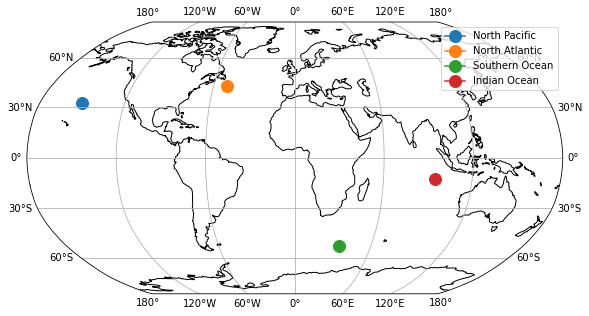

In [137]:
plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(np_lon,np_lat,transform=ccrs.PlateCarree(),label='North Pacific',marker='o',markersize=12)
plt.plot(na_lon,na_lat,transform=ccrs.PlateCarree(),label='North Atlantic',marker='o',markersize=12)
plt.plot(so_lon,so_lat,transform=ccrs.PlateCarree(),label='Southern Ocean',marker='o',markersize=12)
plt.plot(io_lon,io_lat,transform=ccrs.PlateCarree(),label='Indian Ocean',marker='o',markersize=12)
plt.legend()

#### New boxes around the Soutern Ocean

In [3]:
so1_ds = xr.open_dataset("202206_lon:(120,130)_lat:(-60,-55).nc")
so1 = ff.get_ds_interp(so1_ds,0,2000,4)

so2_ds = xr.open_dataset("202206_lon:(-180,-170)_lat:(-60,-55).nc")
so2 = ff.get_ds_interp(so2_ds,0,2000,4)

so3_ds = xr.open_dataset("202206_lon:(-120,-110)_lat:(-60,-55).nc")
so3 = ff.get_ds_interp(so3_ds,0,2000,4)

so4_ds = xr.open_dataset("202206_lon:(-60,-50)_lat:(-60,-55).nc")
so4 = ff.get_ds_interp(so4_ds,0,2000,4)

so5_ds = xr.open_dataset("202206_lon:(0,10)_lat:(-60,-55).nc")
so5 = ff.get_ds_interp(so5_ds,0,2000,4)

so6_ds = xr.open_dataset("202206_lon:(60,70)_lat:(-60,-55).nc")
so6 = ff.get_ds_interp(so6_ds,0,2000,4)

In [138]:
so1_param = [120,130,-60,-55]
so2_param = [-180,-170,-60,-55]
so3_param = [-120,-110,-60,-55]
so4_param = [-60,-50,-60,-55]
so5_param = [0,10,-60,-55]
so6_param = [60,70,-60,-55]

In [139]:
so1_lon,so1_lat=numpy.average((so1_param[0],so1_param[1])),numpy.average((so1_param[2],so1_param[3]))
so2_lon,so2_lat=numpy.average((so2_param[0],so2_param[1])),numpy.average((so2_param[2],so2_param[3]))
so3_lon,so3_lat=numpy.average((so3_param[0],so3_param[1])),numpy.average((so3_param[2],so3_param[3]))
so4_lon,so4_lat=numpy.average((so4_param[0],so4_param[1])),numpy.average((so4_param[2],so4_param[3]))
so5_lon,so5_lat=numpy.average((so5_param[0],so5_param[1])),numpy.average((so5_param[2],so5_param[3]))
so6_lon,so6_lat=numpy.average((so6_param[0],so6_param[1])),numpy.average((so6_param[2],so6_param[3]))

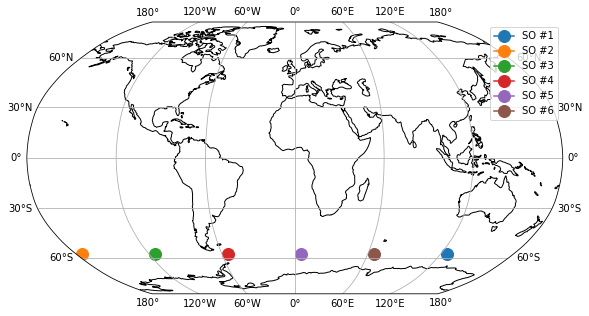

In [140]:
plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(so1_lon,so1_lat,transform=ccrs.PlateCarree(),label='SO #1',marker='o',markersize=12)
plt.plot(so2_lon,so2_lat,transform=ccrs.PlateCarree(),label='SO #2',marker='o',markersize=12)
plt.plot(so3_lon,so3_lat,transform=ccrs.PlateCarree(),label='SO #3',marker='o',markersize=12)
plt.plot(so4_lon,so4_lat,transform=ccrs.PlateCarree(),label='SO #4',marker='o',markersize=12)
plt.plot(so5_lon,so5_lat,transform=ccrs.PlateCarree(),label='SO #5',marker='o',markersize=12)
plt.plot(so6_lon,so6_lat,transform=ccrs.PlateCarree(),label='SO #6',marker='o',markersize=12)
plt.legend()

## MKE/EKE method from Steinberg paper

These eqations are for energy at one spatial scale, where the eddy kinetic energy at scales smaller than the filter scale (EKE) and mean kinetic energy at scales larger than the filter scale (MKE) are:

$$
MKE = <u>^2
$$
$$
EKE = <u^2> - <u>^2
$$

(based on this paper: [Steinberg](https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0269.1.xml))

The methods/functions seem to be working well, but the process of making the calculations repeatedly for multiple locations is a bit complex. I think we need a new set of functions to take an array with temperature and salinity profiles, and return an array with EKE values. Obviously need the ability to switch between temperature and salinity (density, spice, etc) variables. Potential tasks for separate functions:
- Filtering the profiles: use ff.get_filt.single()
- Computing filtered profile, squared (MKE)
- Computing squared profile, filtered
- Computing EKE (difference between the above two values)

Should make a new file EKE_funcs.py with these functions

## Temperature

#### Same boxes and naming conventions as the AGU_poster notebook

In [145]:
np_Tfilt = ff.get_filt_multi(np,10,500,50,bound=True)
na_Tfilt = ff.get_filt_multi(na,10,500,50,bound=True)
so_Tfilt = ff.get_filt_multi(so,10,500,50,bound=True)
io_Tfilt = ff.get_filt_multi(io,10,500,50,bound=True)

In [146]:
np_Tfilt_100 = np_Tfilt.sel(FILT_SCALE=100.)
na_Tfilt_100 = na_Tfilt.sel(FILT_SCALE=100.)
so_Tfilt_100 = so_Tfilt.sel(FILT_SCALE=100.)
io_Tfilt_100 = io_Tfilt.sel(FILT_SCALE=100.)

In [150]:
np_TMKE = np_Tfilt_100**2
na_TMKE = na_Tfilt_100**2
so_TMKE = so_Tfilt_100**2
io_TMKE = io_Tfilt_100**2

In [104]:
np_2 = np[['TEMP', 'PSAL']]**2
na_2 = na[['TEMP', 'PSAL']]**2
so_2 = so[['TEMP', 'PSAL']]**2
io_2 = io[['TEMP', 'PSAL']]**2

In [153]:
np_T2_filt = ff.get_filt_single(np_2,100)
na_T2_filt = ff.get_filt_single(na_2,100)
so_T2_filt = ff.get_filt_single(so_2,100)
io_T2_filt = ff.get_filt_single(io_2,100)

In [157]:
np_TEKE = np_T2_filt - np_TMKE
na_TEKE = na_T2_filt - na_TMKE
so_TEKE = so_T2_filt - so_TMKE
io_TEKE = io_T2_filt - io_TMKE

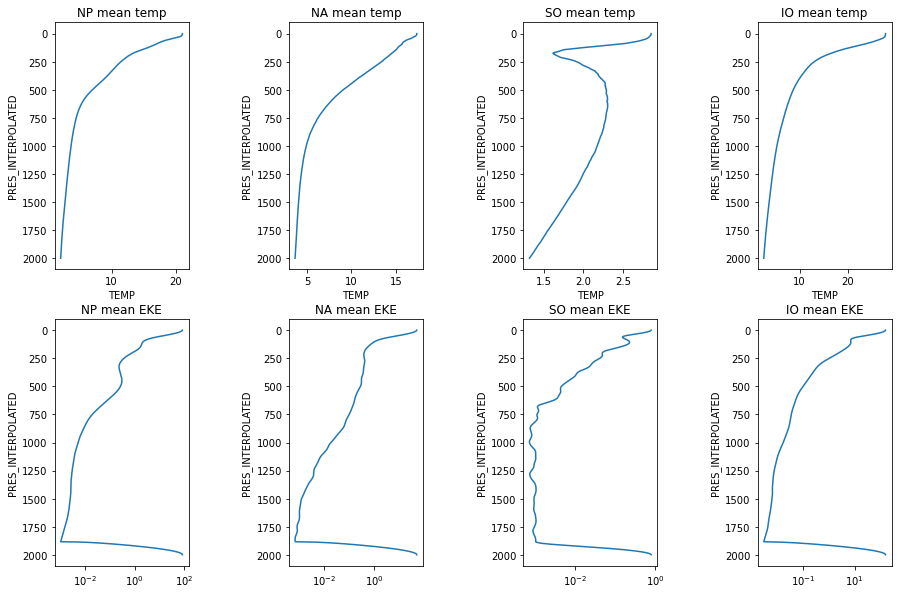

In [158]:
plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
np.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('NP mean temp')

plt.subplot(2,4,2)
na.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('NA mean temp')

plt.subplot(2,4,3)
so.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('SO mean temp')

plt.subplot(2,4,4)
io.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('IO mean temp')

plt.subplot(2,4,5)
np_TEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('NP mean EKE')

plt.subplot(2,4,6)
na_TEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('NA mean EKE')

plt.subplot(2,4,7)
so_TEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('SO mean EKE')

plt.subplot(2,4,8)
io_TEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('IO mean EKE')

plt.subplots_adjust(wspace=0.75)

#### New boxes around the Southern Ocean

In [108]:
so1_filt = ff.get_filt_multi(so1,10,500,50,bound=True)
so2_filt = ff.get_filt_multi(so2,10,500,50,bound=True)
so3_filt = ff.get_filt_multi(so3,10,500,50,bound=True)
so4_filt = ff.get_filt_multi(so4,10,500,50,bound=True)
so5_filt = ff.get_filt_multi(so5,10,500,50,bound=True)
so6_filt = ff.get_filt_multi(so6,10,500,50,bound=True)

In [109]:
so1_filt_100 = so1_filt.sel(FILT_SCALE=100.)
so2_filt_100 = so2_filt.sel(FILT_SCALE=100.)
so3_filt_100 = so3_filt.sel(FILT_SCALE=100.)
so4_filt_100 = so4_filt.sel(FILT_SCALE=100.)
so5_filt_100 = so5_filt.sel(FILT_SCALE=100.)
so6_filt_100 = so6_filt.sel(FILT_SCALE=100.)

In [110]:
so1_MKE = so1_filt_100**2
so2_MKE = so2_filt_100**2
so3_MKE = so3_filt_100**2
so4_MKE = so4_filt_100**2
so5_MKE = so5_filt_100**2
so6_MKE = so6_filt_100**2

In [111]:
so1_2 = so1[['TEMP', 'PSAL']]**2
so2_2 = so2[['TEMP', 'PSAL']]**2
so3_2 = so3[['TEMP', 'PSAL']]**2
so4_2 = so4[['TEMP', 'PSAL']]**2
so5_2 = so5[['TEMP', 'PSAL']]**2
so6_2 = so6[['TEMP', 'PSAL']]**2

In [112]:
so1_TEMP2_filt = ff.get_filt_single(so1_2, 100)
so2_TEMP2_filt = ff.get_filt_single(so2_2, 100)
so3_TEMP2_filt = ff.get_filt_single(so3_2, 100)
so4_TEMP2_filt = ff.get_filt_single(so4_2, 100)
so5_TEMP2_filt = ff.get_filt_single(so5_2, 100)
so6_TEMP2_filt = ff.get_filt_single(so6_2, 100)

In [113]:
so1_EKE = so1_TEMP2_filt - so1_MKE
so2_EKE = so2_TEMP2_filt - so2_MKE
so3_EKE = so3_TEMP2_filt - so3_MKE
so4_EKE = so4_TEMP2_filt - so4_MKE
so5_EKE = so5_TEMP2_filt - so5_MKE
so6_EKE = so6_TEMP2_filt - so6_MKE

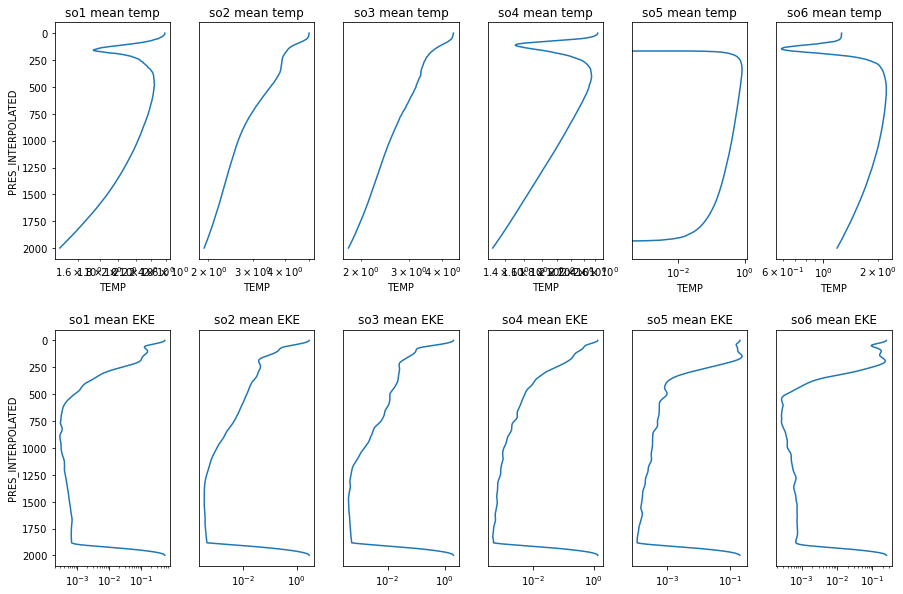

In [114]:
plt.figure(figsize=(15,10))

plt.subplot(2,6,1)
so1.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('so1 mean temp')

plt.subplot(2,6,2)
so2.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so2 mean temp')

plt.subplot(2,6,3)
so3.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so3 mean temp')

plt.subplot(2,6,4)
so4.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so4 mean temp')

plt.subplot(2,6,5)
so5.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so5 mean temp')

plt.subplot(2,6,6)
so6.TEMP.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so6 mean temp')

plt.subplot(2,6,7)
so1_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('so1 mean EKE')

plt.subplot(2,6,8)
so2_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so2 mean EKE')

plt.subplot(2,6,9)
so3_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so3 mean EKE')

plt.subplot(2,6,10)
so4_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so4 mean EKE')

plt.subplot(2,6,11)
so5_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so5 mean EKE')

plt.subplot(2,6,12)
so6_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.title('so6 mean EKE')

plt.subplots_adjust(wspace=0.25, hspace=0.3)

## Salinity

#### Same boxes and naming conventions as the AGU_poster notebook

In [148]:
np_Pfilt = ff.get_filt_multi(np,10,500,50,bound=True,variable='PSAL')
na_Pfilt = ff.get_filt_multi(na,10,500,50,bound=True,variable='PSAL')
so_Pfilt = ff.get_filt_multi(so,10,500,50,bound=True,variable='PSAL')
io_Pfilt = ff.get_filt_multi(io,10,500,50,bound=True,variable='PSAL')

In [149]:
np_Pfilt_100 = np_Pfilt.sel(FILT_SCALE=100.)
na_Pfilt_100 = na_Pfilt.sel(FILT_SCALE=100.)
so_Pfilt_100 = so_Pfilt.sel(FILT_SCALE=100.)
io_Pfilt_100 = io_Pfilt.sel(FILT_SCALE=100.)

In [151]:
np_PMKE = np_Pfilt_100**2
na_PMKE = na_Pfilt_100**2
so_PMKE = so_Pfilt_100**2
io_PMKE = io_Pfilt_100**2

In [154]:
np_P2_filt = ff.get_filt_single(np_2,100,variable='PSAL')
na_P2_filt = ff.get_filt_single(na_2,100,variable='PSAL')
so_P2_filt = ff.get_filt_single(so_2,100,variable='PSAL')
io_P2_filt = ff.get_filt_single(io_2,100,variable='PSAL')

In [155]:
np_PEKE = np_P2_filt - np_PMKE
na_PEKE = na_P2_filt - na_PMKE
so_PEKE = so_P2_filt - so_PMKE
io_PEKE = io_P2_filt - io_PMKE

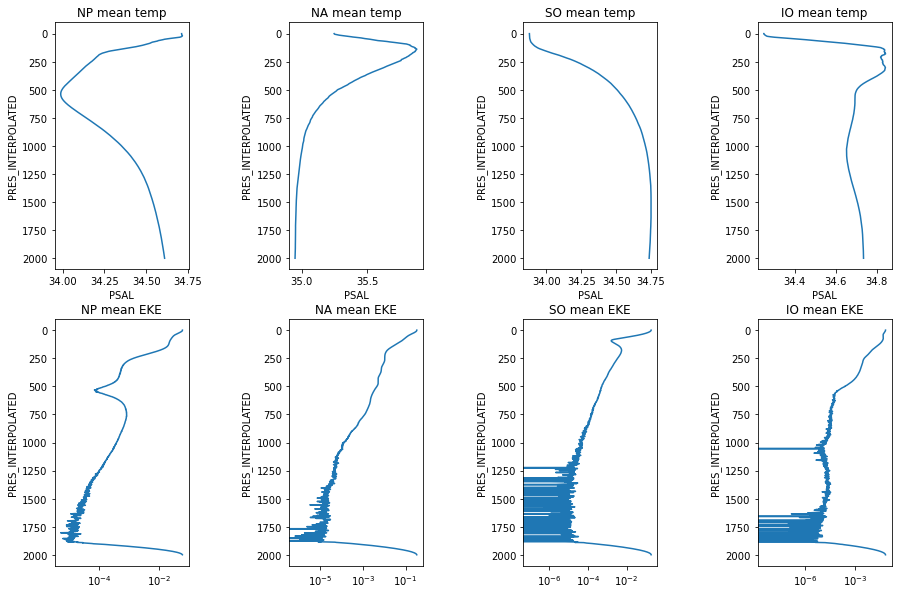

In [159]:
plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
np.PSAL.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('NP mean temp')

plt.subplot(2,4,2)
na.PSAL.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('NA mean temp')

plt.subplot(2,4,3)
so.PSAL.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('SO mean temp')

plt.subplot(2,4,4)
io.PSAL.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('IO mean temp')

plt.subplot(2,4,5)
np_PEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('NP mean EKE')

plt.subplot(2,4,6)
na_PEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('NA mean EKE')

plt.subplot(2,4,7)
so_PEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('SO mean EKE')

plt.subplot(2,4,8)
io_PEKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('IO mean EKE')

plt.subplots_adjust(wspace=0.75)

Need to come back to this plot, the EKE lines don't look right at all with the lines back and forth...

#### New boxes around the Southern Ocean